In [1]:
import numpy as np
import pandas as pd
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from matplotlib.ticker import FuncFormatter

import datetime
import time
import os
import pytz
import json
import csv

from pprint import pprint


In [2]:
# GLOBAL SETTINGS

# Data directories
#coin_dataDir = 'DATA/TESTDIR/' # Debug dir for testing I/O logic and/or issues. It should be a clone of the above dir.
coin_dataDir = 'DATA/COMBINEDDATA/'
plot_dataDir = 'DATA/INITIAL_INSIGHTS/PCA_FACTORS'
riskFactor_dataDir = 'DATA/RISKFACTORSDATA/'


# Date ranges
START = 2020
END = 2022

# Helpers
idx = pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

# END GLOBAL SETTINGS

In [3]:
# FINDING RISK FACTORS WITH PCA

# Read in MDF with initial coin pool
cpool_mdf = pd.read_csv(coin_dataDir + 'CoinPool.csv')
cpool_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
cpool_mdf['Dates'] = pd.to_datetime(cpool_mdf['Dates'])
cpool_mdf.set_index(['Dates', 'Coin'], inplace=True)
print(cpool_mdf.columns)


# Isolate the close prices and calculate daily returns
returns_df = cpool_mdf.loc[idx[str(START):str(END), :], 'Close'].unstack('Coin').pct_change()

# Winsorize at 2.5% and 97.5% quantiles
returns_df = returns_df.clip(lower=returns_df.quantile(q=.025),
                       upper=returns_df.quantile(q=.975),
                       axis=1)

# Drop coins and adates that do not have complete data for 95%  of the time period
returns_df = returns_df.dropna(thresh=int(returns_df.shape[0] * .95), axis=1)
returns_df = returns_df.dropna(thresh=int(returns_df.shape[1] * .95))

# Saved the returns as they are for comparison to Eigenportfolios at the end of the script
base_returns = returns_df
#print("After Dropping coins for missing data")
#print(returns_df.info())

# impute any remaining missing values using daily average returns
daily_avg = returns_df.mean(1)
returns_df = returns_df.apply(lambda x: x.fillna(daily_avg))
print(returns_df.info())

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2020-01-02 to 2022-01-14
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   algorand               744 non-null    float64
 1   arweave                744 non-null    float64
 2   basic-attention-token  744 non-null    float64
 3   binancecoin            744 non-null    float64
 4   bitcoin                744 non-null    float64
 5   bitcoin-cash           744 non-null    float64
 6   bitcoin-cash-sv        744 non-null    float64
 7   bittorrent-2           744 non-null    float64
 8   cardano                744 non-null    float64
 9   chainlink              744 non-null    float64
 10  cosmos                 744 non-null    float64
 11  crypto-com-chain       744 non-null    float64
 12  dash                   744 non-null    float64
 13  decentralan

In [4]:
# Verify no NaNs left in the data
for c in returns_df:
    print(c + " " + str(returns_df[c].isnull().sum()))

algorand 0
arweave 0
basic-attention-token 0
binancecoin 0
bitcoin 0
bitcoin-cash 0
bitcoin-cash-sv 0
bittorrent-2 0
cardano 0
chainlink 0
cosmos 0
crypto-com-chain 0
dash 0
decentraland 0
dogecoin 0
ecomi 0
enjincoin 0
eos 0
ethereum 0
ethereum-classic 0
fantom 0
ftx-token 0
harmony 0
iota 0
kadena 0
kucoin-shares 0
leo-token 0
litecoin 0
loopring 0
maker 0
matic-network 0
monero 0
okb 0
ripple 0
stellar 0
terra-luna 0
tezos 0
theta-token 0
tron 0
vechain 0
zcash 0


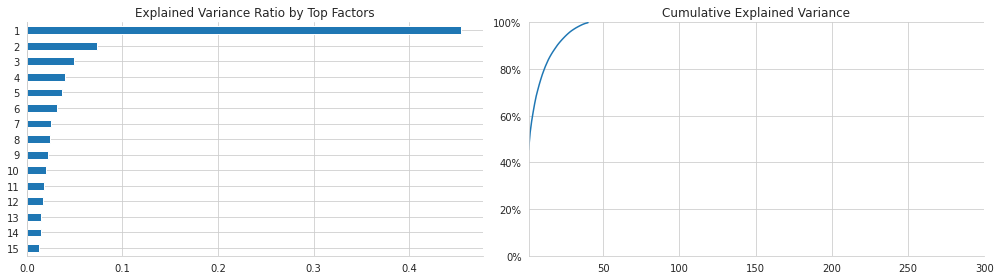

In [5]:
# Use the defaults for PCA to computer principle components of the returns
pca = PCA(n_components='mle')
fitted_returns = pca.fit(returns_df)
#print(fitted_returns)

# Plot the Explained Variance and Top Factors
# The top Factors found by PCA can be used as the "Risk Factors" for our model instead of the FAMA-French Risk Factors
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(fitted_returns.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title,
                                           ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 300))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.tight_layout()

In [6]:
'''
It appears the most important factor explains well over 40% of the daily return variation.
Furthermore, it looks like about 10 factors explain 80% of the returns in our cross section of 40 crypto coins.
About 5 coins explain 60% of the returns. 
Though the initial pool of coins was larger than 40 we dropped several due to lack of data.
'''

# Isolate the first X factors
risk_factors = pd.DataFrame(pca.transform(returns_df)[:, :6],
                            columns=['Principal Component 1', 'Principal Component 2','Principal Component 3',
                                     'Principal Component 4', 'Principal Component 5','Principal Component 6'],
                            index=returns_df.index)

#print("PCA RISK FACTOR DATA")
#print(risk_factors.info())

# Save the Risk Factor data data
if isdir == False:
    os.makedirs(riskFactor_dataDir)
    print("Directory '% s' created" % riskFactor_dataDir)
    risk_factors.to_hdf(f'{riskFactor_dataDir}PCA_Risk_Factors.h5', 'PCA_Risk_Factors')
    risk_factors.to_csv(f'{riskFactor_dataDir}PCA_Risk_Factors.csv')
    print(f"The PCA Factors data has been saved to {riskFactor_dataDir} as a MultiIndex dataframe")

else:
    risk_factors.to_hdf(f'{riskFactor_dataDir}PCA_Risk_Factors.h5', 'PCA_Risk_Factors')
    risk_factors.to_csv(f'{riskFactor_dataDir}PCA_Risk_Factors.csv')
    print(f"The PCA Factors data has been saved to {riskFactor_dataDir} as a MultiIndex dataframe")



# Verify factor correlation or non-correlation
factor_corr_1_1 = risk_factors['Principal Component 1'].corr(risk_factors['Principal Component 1'])
factor_corr_1_2 = risk_factors['Principal Component 1'].corr(risk_factors['Principal Component 2'])
factor_corr_1_3 = risk_factors['Principal Component 1'].corr(risk_factors['Principal Component 3'])
factor_corr_1_4 = risk_factors['Principal Component 1'].corr(risk_factors['Principal Component 4'])
factor_corr_1_5 = risk_factors['Principal Component 1'].corr(risk_factors['Principal Component 5'])
factor_corr_1_6 = risk_factors['Principal Component 1'].corr(risk_factors['Principal Component 6'])
factor_corr_2_3 = risk_factors['Principal Component 2'].corr(risk_factors['Principal Component 3'])
factor_corr_2_4 = risk_factors['Principal Component 2'].corr(risk_factors['Principal Component 4'])
factor_corr_2_5 = risk_factors['Principal Component 2'].corr(risk_factors['Principal Component 5'])

print("Factor Correlations")
print("Factors 1 & 1 " + str(factor_corr_1_1))
print("Factors 1 & 2 " + str(factor_corr_1_2))
print("Factors 1 & 3 " + str(factor_corr_1_3))
print("Factors 2 & 3 " + str(factor_corr_2_3))
print("Factors 1 & 4 " + str(factor_corr_1_4))
print("Factors 1 & 5 " + str(factor_corr_1_5))
print("Factors 1 & 6 " + str(factor_corr_1_6))
print("Factors 2 & 4 " + str(factor_corr_2_4))
print("Factors 2 & 5 " + str(factor_corr_2_5))

Factor Correlations
Factors 1 & 1 1.0
Factors 1 & 2 9.257878481944286e-15
Factors 1 & 3 -1.0365539164762681e-16
Factors 2 & 3 1.8490149832643978e-16
Factors 1 & 4 -2.8782670296107615e-17
Factors 1 & 5 -4.761261446173669e-16
Factors 1 & 6 -5.530508512398761e-16
Factors 2 & 4 -3.4600587948360746e-17
Factors 2 & 5 6.978309833332204e-17


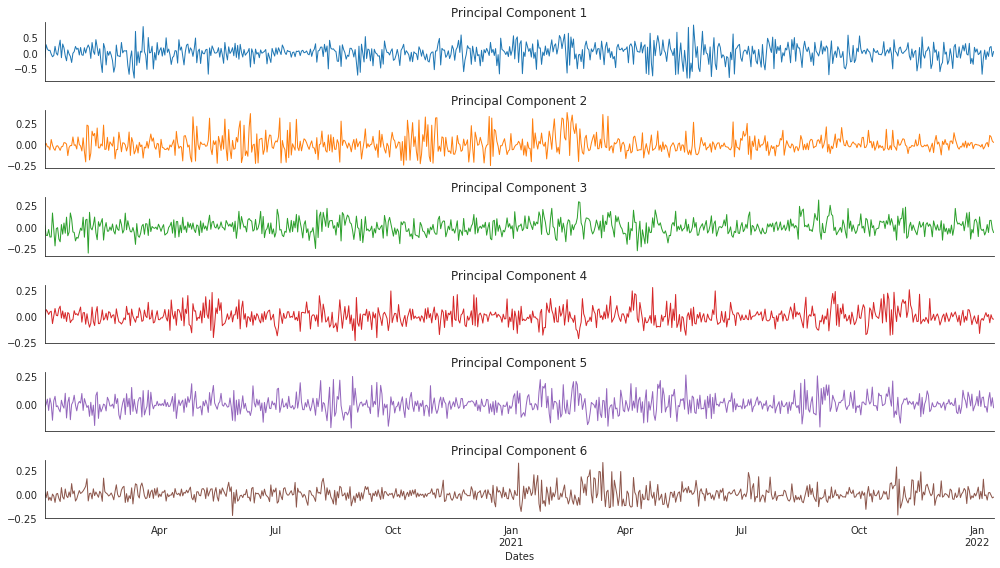

In [7]:
'''
In this case factors 1 and 2 are pretty correlated. But factors 1 and 3 are far less correlated, factors 2 and 3 are
less correlated than factors 1 and 2.
'''

#  Plot with Seaborn
with sns.axes_style('white'):
    risk_factors.plot(subplots=True,
                      figsize=(14, 8),
                      title=risk_factors.columns.tolist(),
                      legend=False,
                      rot=0,
                      lw=1,
                      xlim=(risk_factors.index.min(),
                            risk_factors.index.max()))

    sns.despine()
    plt.tight_layout()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Trial                1000 non-null   int64  
 1   Principal Component  1000 non-null   int64  
 2   Value                1000 non-null   float64
 3   Cumulative           1000 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 31.4 KB
None


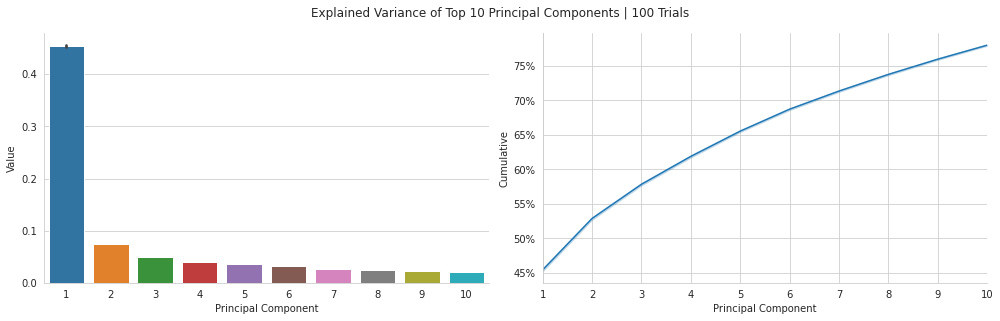

In [8]:
# Same as above but with 100 trials

# Isolate the close prices and calculate daily returns
returns_df = cpool_mdf.loc[idx[str(START):str(END), :], 'Close'].unstack('Coin').pct_change()
#print("Regenerate daily Returns")
#print(returns_df.info())

# Winsorize at 2.5% and 97.5% quantiles
returns_df = returns_df.clip(lower=returns_df.quantile(q=.025),
                       upper=returns_df.quantile(q=.975),
                       axis=1)
#print("Winsorize again daily Returns")
#print(returns_df.info())

# Fit PCA and do the trials
pca = PCA()
n_trials, n_samples = 100, 500
explained = np.empty(shape=(n_trials, n_samples))

# The trials
for trial in range(n_trials):
    returns_sample = returns_df.sample(n=n_samples)
    returns_sample = returns_sample.dropna(thresh=int(returns_sample.shape[0] * .95), axis=1)
    returns_sample = returns_sample.dropna(thresh=int(returns_sample.shape[1] * .95))
    daily_avg = returns_sample.mean(1)
    returns_sample = returns_sample.apply(lambda x: x.fillna(daily_avg))
    #print("After Dropping coins for missing data")
    #print(returns_sample.info())
    fitted_returns = pca.fit(returns_sample)
    explained[trial, :len(pca.components_)] = fitted_returns.explained_variance_ratio_

#pprint(explained)

explained = pd.DataFrame(explained, columns=list(range(1, explained.shape[1] + 1)))
#print("All the explained covariance PCA components")
#print(explained.info())

# Plot with Seaborn
fig, axes = plt.subplots(ncols=2, figsize=(14, 4.5))
pc10 = explained.iloc[:, :10].stack().reset_index()
pc10.columns = ['Trial', 'Principal Component', 'Value']

pc10['Cumulative'] = pc10.groupby('Trial').Value.transform(np.cumsum)
print(pc10.info())
sns.barplot(x='Principal Component', y='Value', data=pc10, ax=axes[0])
sns.lineplot(x='Principal Component', y='Cumulative', data=pc10, ax=axes[1])
axes[1].set_xlim(1, 10)
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
fig.suptitle('Explained Variance of Top 10 Principal Components | 100 Trials')
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.90)


In [9]:
# EIGENPORTFOLIO

# Searching for a weights to weigh the coins in a future portfolio.
# Visualizing the PCA factors in this way can also help decide which of the componenets to use
# As features in the dataset representing risk factors
# Read in MDF with initial coin pool
cpool_mdf = pd.read_csv(coin_dataDir + 'CoinPool.csv')
cpool_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
cpool_mdf['Dates'] = pd.to_datetime(cpool_mdf['Dates'])
cpool_mdf.set_index(['Dates', 'Coin'], inplace=True)

top15 = cpool_mdf.loc['2022-01-07' , 'Market Cap'].nlargest(15)
top15 = top15.reset_index( level =1 )
top15.index = top15['Coin']
top15.drop('Coin',axis=1,inplace=True)
print(top15)

                    Market Cap
Coin                          
bitcoin           7.930510e+11
ethereum          3.821842e+11
binancecoin       7.574553e+10
solana            4.330671e+10
cardano           3.921656e+10
ripple            3.631377e+10
polkadot          2.714258e+10
terra-luna        2.543363e+10
avalanche-2       2.162580e+10
dogecoin          2.057626e+10
shiba-inu         1.613740e+10
matic-network     1.454294e+10
crypto-com-chain  1.200827e+10
chainlink         1.188291e+10
cosmos            1.183044e+10


In [10]:
# Calculate the returns for  the top 15 coins based on Market Capitalization
returns_df = cpool_mdf.loc[idx[str(START):str(END), top15.index], 'Close'].unstack('Coin').pct_change()
#print(returns_df.info())

# Winsorize at 2.5% and 97.5% quantiles
returns_df = returns_df.clip(lower=returns_df.quantile(q=.025),
                       upper=returns_df.quantile(q=.975),
                       axis=1)

# Base pool of top 15 by Mcap, for measures the Eigenportfolio performance at the end of the script
base_returns2 = returns_df

# Normalize/Scale
normed_returns_df = pd.DataFrame(scale(returns_df
                       .clip(lower=returns_df.quantile(q=.025),
                             upper=returns_df.quantile(q=.975),
                             axis=1)
                      .apply(lambda x: x.sub(x.mean()).div(x.std()))), columns = returns_df.columns,index=returns_df.index)

print(normed_returns_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 745 entries, 2020-01-01 to 2022-01-14
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   binancecoin       744 non-null    float64
 1   bitcoin           744 non-null    float64
 2   cardano           744 non-null    float64
 3   chainlink         744 non-null    float64
 4   cosmos            744 non-null    float64
 5   crypto-com-chain  744 non-null    float64
 6   dogecoin          744 non-null    float64
 7   ethereum          744 non-null    float64
 8   matic-network     744 non-null    float64
 9   ripple            744 non-null    float64
 10  terra-luna        744 non-null    float64
 11  solana            644 non-null    float64
 12  shiba-inu         531 non-null    float64
 13  polkadot          514 non-null    float64
 14  avalanche-2       479 non-null    float64
dtypes: float64(15)
memory usage: 93.1 KB
None
<class 'pandas.core.frame.Data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2020-01-02 to 2022-01-14
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   binancecoin       744 non-null    float64
 1   bitcoin           744 non-null    float64
 2   cardano           744 non-null    float64
 3   chainlink         744 non-null    float64
 4   cosmos            744 non-null    float64
 5   crypto-com-chain  744 non-null    float64
 6   dogecoin          744 non-null    float64
 7   ethereum          744 non-null    float64
 8   matic-network     744 non-null    float64
 9   ripple            744 non-null    float64
 10  terra-luna        744 non-null    float64
dtypes: float64(11)
memory usage: 69.8 KB
None
Explained Variance    0.823696
dtype: float64
   Explained Variance
0            0.380398
1            0.175786
2            0.109942
3            0.084469
4            0.073102
<class 'pandas.core.frame.DataFrame'>
In

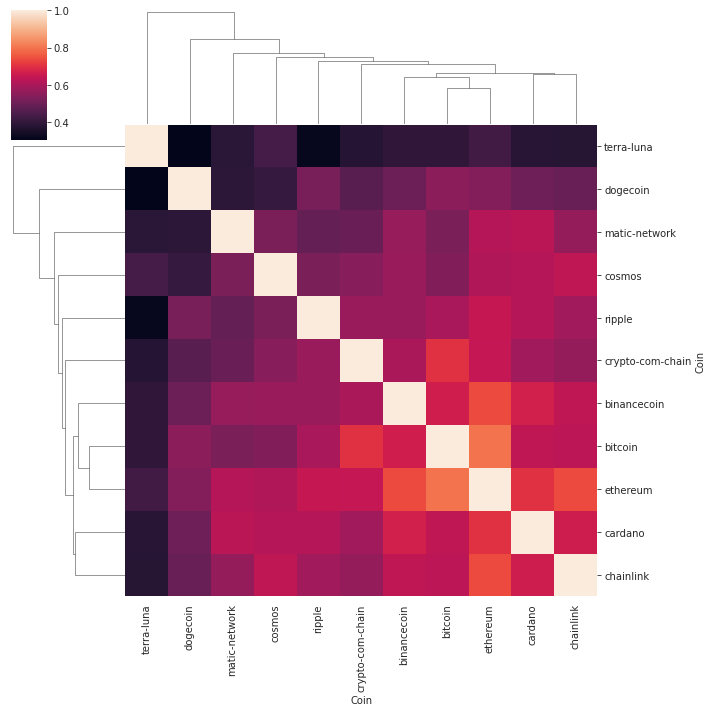

In [11]:
# Drop coins and dates that do not have complete data for 95%  of the time period
normed_returns_df = normed_returns_df.dropna(thresh=int(normed_returns_df.shape[0] * .95), axis=1)
normed_returns_df = normed_returns_df.dropna(thresh=int(normed_returns_df.shape[1] * .95))

# To compare against wieghted Eigenportfolios at the end of the script
scaled_base_returns = normed_returns_df
print("After dropping coins that have data for less than 95% of the total periods we want".upper())
print(normed_returns_df.info())

# Apply np.cov() to the normalized returns to see the strength of correlation among the coin returns
cov = normed_returns_df.cov()
covariance_map = sns.clustermap(cov)
covariance_map.savefig(plot_dataDir + 'Top_15_Covariance_Cluster_map.png')

# Feed the correlated returns to PCA and check which factors explain the most growth
pca = PCA()
pca = pca.fit(cov)
exp_var15 = pd.Series(pca.explained_variance_ratio_).to_frame('Explained Variance')
print("Explained growth by factors according to PCA".upper())
print(exp_var15.head().sum())
print(exp_var15.head())

# Normalize the four largest components PCA components so that they sum to 1
# Prepare to use them as weights for portfolios to compare to an equal-weighted portfolio formed from all coins
# In this case all the coins in the coin pool
top4 = pd.DataFrame(pca.components_[:4], columns=cov.columns)
eigen_portfolios = top4.div(top4.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range(1, 5)]
print(eigen_portfolios.info())

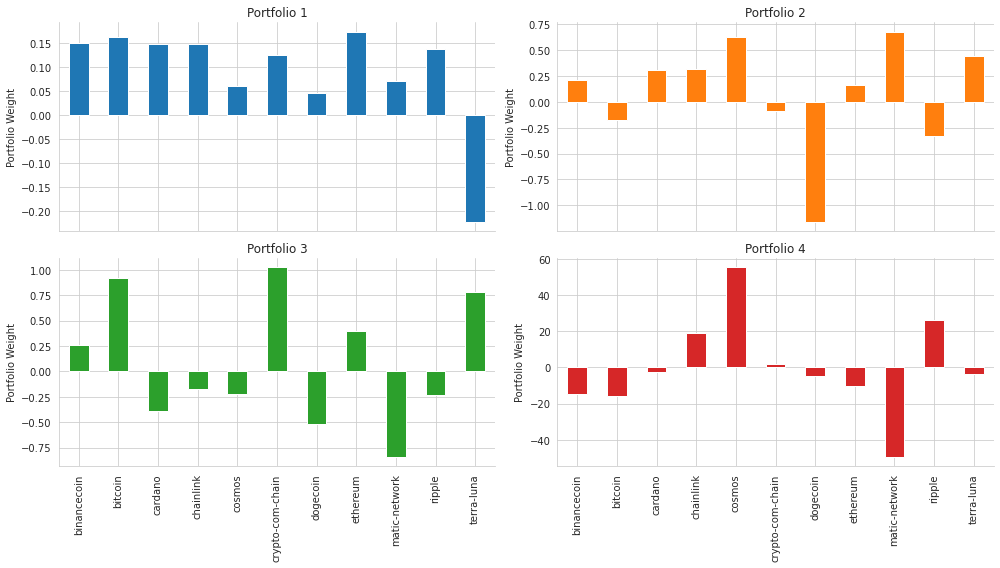

In [12]:
# Visualize the Eigenportfolio weights
axes = eigen_portfolios.T.plot.bar(subplots=True,
                                   layout=(2, 2),
                                   figsize=(14, 8),
                                   legend=False)
for ax in axes.flatten():
    ax.set_ylabel('Portfolio Weight')
    ax.set_xlabel('')
sns.despine()
plt.tight_layout()

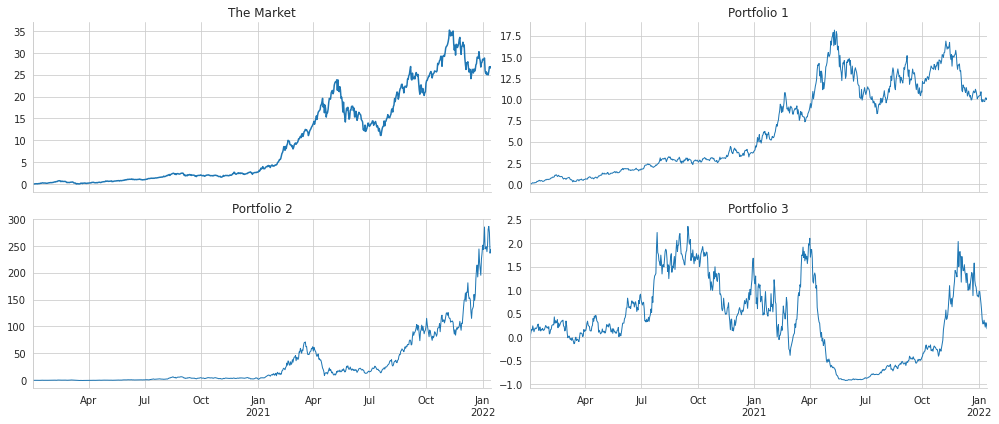

In [13]:
# Visualize the performance of the Eigenportfolios
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True)
axes = axes.flatten()
base_returns.mean(1).add(1).cumprod().sub(1).plot(title='The Market', ax=axes[0])
for i in range(3):
    rc = base_returns.mul(eigen_portfolios.iloc[i]).sum(1).add(1).cumprod().sub(1)
    rc.plot(title=f'Portfolio {i+1}', ax=axes[i+1], lw=1, rot=0)

for i in range(4):
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout()